In [1]:
#from nn.nn import NN
import gymnasium as gym
from agent.agent import AgentBuilder, ActionContext
from experience.experience import ExperienceBuffer
import torch
import torch.nn as NN
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
ENV_NAME = 'FrozenLake-v1'
EPSILON = 1
EPSILON_DECAY = 20000
#EPSILON_DECAY = 1000
EPSILON_DECAY_VALUE = 0 
POLICY = 'GREEDY'
ACTION_METHOD = 'NEURAL_NETWORK'
EXPERIENCE_BUFFER = 300
#EXPERIENCE_BUFFER = 50
SAMPLE_SIZE = 50
SYNCHRONIZATION_RATE = 50
LEARNING_RATE = 0.01
GAMMA = 0.95
HIDDEN_DIMENSION = (15, 15, 15)
A_FUNCTION = torch.nn.ReLU()
LOSS_F=torch.nn.MSELoss()
OPTIMIZER=torch.optim.Adam
STEPS_TO_PLAY = 40000
#STEPS_TO_PLAY = 3000

Create environment to play with:

In [3]:
    
env = gym.make(ENV_NAME, desc=None, map_name="8x8", is_slippery=False,
                render_mode="rgb_array")
starting_state, _ = env.reset()

C:\Users\Kacper\AppData\Local\Temp\ipykernel_24468\3393359653.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


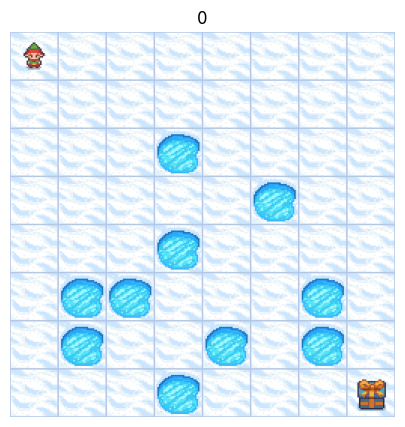

In [4]:
#import seaborn as sns

def print_frame(env_, number):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
    ax.imshow(env_.render())
    ax.axis("off")
    ax.set_title(number)
    fig.show()

print_frame(env, 0)   
# def policy_plot(model):
    
#     directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
#     for i in range(15):
        
    
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
#     sns.heatmap(
#         data,
#         annot=qtable_directions,
#         fmt="",
#         ax=ax[1],
#         cmap=sns.color_palette("Blues", as_cmap=True),
#         linewidths=0.7,
#         linecolor="black",
#         xticklabels=[],
#         yticklabels=[],
#         annot_kws={"fontsize": "xx-large"},
#     ).set(title="Learned Q-values\nArrows represent best action")
    
#     for _, spine in ax[1].spines.items():
#         spine.set_visible(True)
#         spine.set_linewidth(0.7)
#         spine.set_color("black")
#     img_title = f"frozenlake_q_values.png"
#     fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
#     plt.show()

Create prediction/on-line neural network.

In [5]:

# nn = NN(
#     nb_of_state_variables = 16,
#     nb_of_output_values=env.action_space.n,
#     activation_functions= A_FUNCTION,
#     hidden_dims=HIDDEN_DIMENSION,
#     add_biases=True
#     )

from sklearn.preprocessing import OneHotEncoder


class PipeLine(NN.Linear):
    
    def __init__(self, in_features, out_features):
        self.one_hot_encoder = OneHotEncoder().fit(list([i] for i in range(in_features)))
        
        super().__init__(in_features = in_features, out_features = out_features, bias = False)
        
    def forward(self, state):
        state = state.numpy()
        if len(state.shape) < 2:
           state = state.reshape(-1, 1)
        state = self.one_hot_encoder.transform(state).toarray()
        state = torch.from_numpy(state)
        state = state.type(torch.float32)
        return super().forward(state)
        
nn = PipeLine(in_features=env.observation_space.n, out_features=env.action_space.n,)

Some theory:

Assumption for supervised learning with gradient descent:
1) data must by independent
2) identically distributed
3) target needs to be stationary
However for reinforcement learning these assumption are not kept.

Three classic optimization technics in ML:
1) Batch gradient descent -> taking all samples at once. Not practical -> to large data sets
2) Mini batch gradient descent -> taking small portion of samples
3) Stochastic gradient descent -> taking one sample per step. High variance per step of optimization. Less stable then mini-batch gradient descent
The bigger the sample space, the lower the variance of the steps. To large sample to slow process of learning. In order to use mini-batch gradient descent experience is gathered.

Problems with classical RL methods:

* Problem 1 - Collected samples comes from the same trajectory and policy. Experience gathered in state t+1 depends on the state t. So experience will looks like (t -> t+1 -> t+2 -> t+3). In each time information about variables of a current state, variables of a previous state and reward are kept. When target network is updated and then samples are collected a mini-batch comes from older policy. What's more batches are correlated with each other. It violate assumptions that data are independent (correlation between batches) and identically distributed (policy is changing so the samples distribution are changing)


* Problem 2 - Weights are optimized for all states at once. When using the same target network and optimization network it creates non-stationary target. This means that the values estimated by a target network maybe outdated. Moreover target shifts its values when the network weights are updated.

Value_estimated_by_neural_network_for_current_state = Reward + gamma * max(Value_estimated_by_neural_network_for_next_state)

Solving issues with IID:
Solution to the Problem 1: Using batches -> Collecting data with use of the same neural network. Improvements to that solution could be use of replay buffer. Having ExperienceBuffer from which samples are taken much higher than batches use for learning. Old diverse experience can halp learning. Samples are information about state and action and consequence of this action (variables describing next state and reward).

Solution with a framework: \
size_of_buffer >> size_of_sample

eg. \
    exp = ExperienceBuffer(size_of_buffer=1000)
    samples = exp.get_samples(100)

Important: Neural Networks are used to estimate consequences of a transition. Loss function is used to evaluate how consequences were estimated.

In [6]:
exp = ExperienceBuffer(
    size_of_buffer=EXPERIENCE_BUFFER, 
    sampling_method='SIMPLE_RANDOM'
    )

Solution to the Problem 2:  Using different target network -> it tends to solve problems with non-stationary of a target. One network is used to evaluate value of a target (Value_estimated_by_neural_network_for_next_state) and another is used to optimize its weights to better estimate consequences of a transitions between two states after taking action. After several iteration weights of both neural networks are synchronized. 

Remark: This are not really a different network. The architecture is the same only weights are different.

In order to use different target network synchronization attribute must be set:

In [7]:

action_context = ActionContext(
    actions_number=env.action_space.n,
    action_methods=ACTION_METHOD,
    epsilon = EPSILON,
    nn = nn,
    policy= POLICY,
    epsilon_decay=EPSILON_DECAY,
    epsilon_decay_value=EPSILON_DECAY_VALUE
)

agent = AgentBuilder(
    action_context,
    env=env,
    gamma=GAMMA,
    loss_function=LOSS_F,
    optimizer=OPTIMIZER,
    learning_rate=LEARNING_RATE,
    synchronization = SYNCHRONIZATION_RATE # after how many step synchronization will be made
    ).build_agent()

agent.trigger_decay = False

In [8]:
counter = 0
episode_steps = 0
trigger = True

episode_steps_all = []

reward_every_100_episodes = []
reward = []

while counter <= STEPS_TO_PLAY:
    if counter % 100 == 0:
        reward_every_100_episodes.append(sum(reward)/len(reward) if len(reward) > 0 else 0)
        reward = []
    
    if counter % 1000 == 0:
        print(f'Step nb: {counter}')
    
    # gathering experience
    starting_state = torch.tensor([starting_state], dtype=torch.float)
    starting_state.unsqueeze(0)
    
    action = agent.compute_action(starting_state)
    exp_s = agent.make_step(action, starting_state[0].item())
    #print(f'state: {exp_s.state}, previous_state: {exp_s.previous_state}, action: {exp_s.action}')
    #print_frame(agent.env, counter)
    exp.append(exp_s)
    starting_state = exp_s.state
    if exp_s.terminated:
        reward.append(exp_s.reward)
        starting_state, _ = agent.env.reset()
        if exp_s.reward == 1:
            if trigger:
                agent.trigger_decay = True
                trigger = False
            print(f'Epsilon {agent.action.epsilon}')
            print(f'Episode ended after steps: {episode_steps}, Reward = {exp_s.reward}')
            
        episode_steps_all.append(episode_steps)
        episode_steps = 0
        
    
    # train agent
    if len(exp) >= EXPERIENCE_BUFFER:
        samples = exp.get_samples(SAMPLE_SIZE)
        agent.train_agent(samples)
        
    # synchronization
    agent.synchronize(counter)
    
    counter +=1
    episode_steps +=1

Step nb: 0
Step nb: 1000
Epsilon 1
Episode ended after steps: 59, Reward = 1.0
Step nb: 2000
Epsilon 0.9178
Episode ended after steps: 85, Reward = 1.0
Step nb: 3000
Step nb: 4000
Epsilon 0.8156
Episode ended after steps: 50, Reward = 1.0
Step nb: 5000
Epsilon 0.7995
Episode ended after steps: 86, Reward = 1.0
Epsilon 0.7614
Episode ended after steps: 42, Reward = 1.0
Epsilon 0.7603
Episode ended after steps: 22, Reward = 1.0
Step nb: 6000
Epsilon 0.7486999999999999
Episode ended after steps: 23, Reward = 1.0
Epsilon 0.74455
Episode ended after steps: 29, Reward = 1.0
Epsilon 0.7361
Episode ended after steps: 32, Reward = 1.0
Epsilon 0.73415
Episode ended after steps: 28, Reward = 1.0
Epsilon 0.7133499999999999
Episode ended after steps: 57, Reward = 1.0
Step nb: 7000
Epsilon 0.6719999999999999
Episode ended after steps: 20, Reward = 1.0
Epsilon 0.6548
Episode ended after steps: 23, Reward = 1.0
Step nb: 8000
Epsilon 0.64425
Episode ended after steps: 36, Reward = 1.0
Epsilon 0.64235
E

In [9]:
from torch import argmax
import numpy as np

values = []
annots = []

for i in range(env.observation_space.n):
    vals = agent.model(torch.tensor([i], dtype=torch.float)).detach()
    annots.append('   {:.2f}    \n\n{:.2f}      {:.2f}\n\n    {:.2f}   '
                  .format(vals[0, 3].item(), vals[0, 0].item(), vals[0,2].item(), vals[0,1].item()))
    values.append(torch.max(vals))
    print(f'{i}: {vals}, \
          {argmax(agent.model(torch.tensor([i], dtype=torch.float)))}')
    
vals = np.array(values).reshape(int(np.sqrt(env.observation_space.n)), -1)
annots = np.array(annots).reshape(int(np.sqrt(env.observation_space.n)), -1)


0: tensor([[0.4877, 0.5133, 0.5133, 0.4877]]),           1
1: tensor([[0.4862, 0.5404, 0.5404, 0.5133]]),           1
2: tensor([[0.5133, 0.5446, 0.5688, 0.5404]]),           2
3: tensor([[0.5404, 0.5987, 0.5987, 0.5688]]),           1
4: tensor([[0.5688, 0.6302, 0.6302, 0.5987]]),           1
5: tensor([[0.5987, 0.6634, 0.6634, 0.6303]]),           1
6: tensor([[0.6302, 0.6983, 0.6983, 0.6662]]),           2
7: tensor([[0.6649, 0.7351, 0.6984, 0.6991]]),           1
8: tensor([[0.5133, 0.4878, 0.5404, 0.4877]]),           2
9: tensor([[0.5133, 0.5193, 0.5688, 0.5133]]),           2
10: tensor([[0.5404, 0.5404, 0.5987, 0.5404]]),           2
11: tensor([[ 5.6882e-01, -7.8509e-08,  6.3025e-01,  5.6880e-01]]),           2
12: tensor([[0.5987, 0.6634, 0.6634, 0.5987]]),           1
13: tensor([[0.6302, 0.6983, 0.6983, 0.6302]]),           1
14: tensor([[0.6636, 0.7351, 0.7351, 0.6634]]),           1
15: tensor([[0.6983, 0.7738, 0.7351, 0.6983]]),           1
16: tensor([[0.4922, 0.5134, 0

<Axes: >

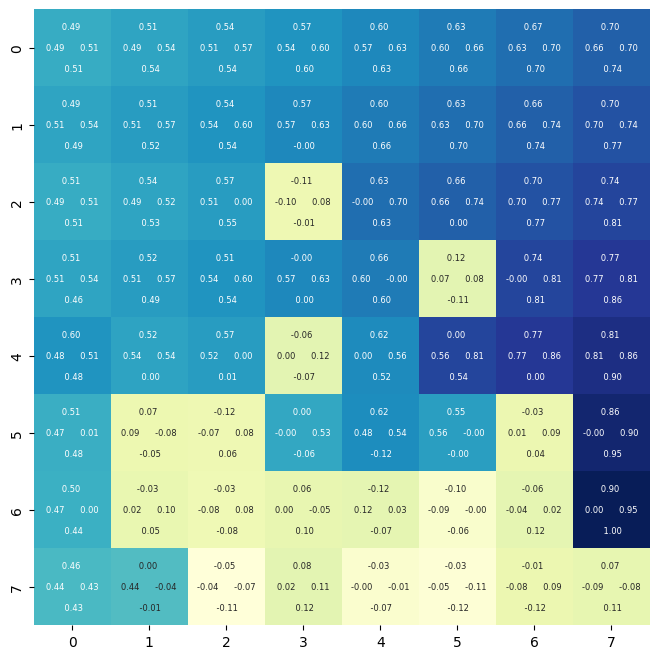

In [10]:
import seaborn as sns
plt.figure(figsize=(8, 8))
sns.heatmap(vals,  cmap="YlGnBu", annot=annots, cbar=False, square=True, fmt="", annot_kws={"fontsize":6})

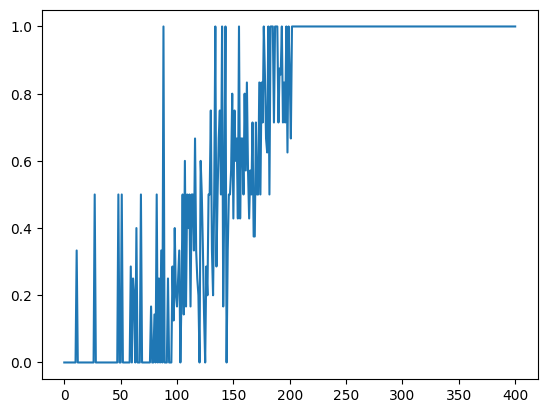

In [11]:
plt.plot(reward_every_100_episodes)
plt.show()

In [12]:

for name, data in agent.model.named_parameters():
    print(name, data.data)

weight tensor([[ 4.8767e-01,  4.8617e-01,  5.1334e-01,  5.4036e-01,  5.6880e-01,
          5.9874e-01,  6.3025e-01,  6.6490e-01,  5.1334e-01,  5.1333e-01,
          5.4036e-01,  5.6882e-01,  5.9874e-01,  6.3025e-01,  6.6360e-01,
          6.9834e-01,  4.9218e-01,  4.9281e-01,  5.1288e-01, -1.0232e-01,
         -1.6532e-10,  6.6342e-01,  6.9834e-01,  7.3509e-01,  5.1017e-01,
          5.1338e-01,  5.4023e-01,  5.6883e-01,  5.9872e-01,  7.1804e-02,
         -6.2170e-14,  7.7378e-01,  4.8442e-01,  5.4414e-01,  5.1843e-01,
          1.3527e-03,  4.9673e-12,  5.5633e-01,  7.7378e-01,  8.1451e-01,
          4.7193e-01,  8.8970e-02, -7.2691e-02, -4.6925e-06,  4.8315e-01,
          5.6374e-01,  8.5874e-03, -5.4434e-15,  4.6840e-01,  2.3087e-02,
         -8.0764e-02,  3.6507e-03,  1.1818e-01, -8.9569e-02, -4.4513e-02,
          2.6226e-04,  4.3812e-01,  4.4308e-01, -4.3256e-02,  2.4535e-02,
         -3.0212e-03, -4.6589e-02, -8.3488e-02, -8.8903e-02],
        [ 5.1334e-01,  5.4036e-01,  5.4460e

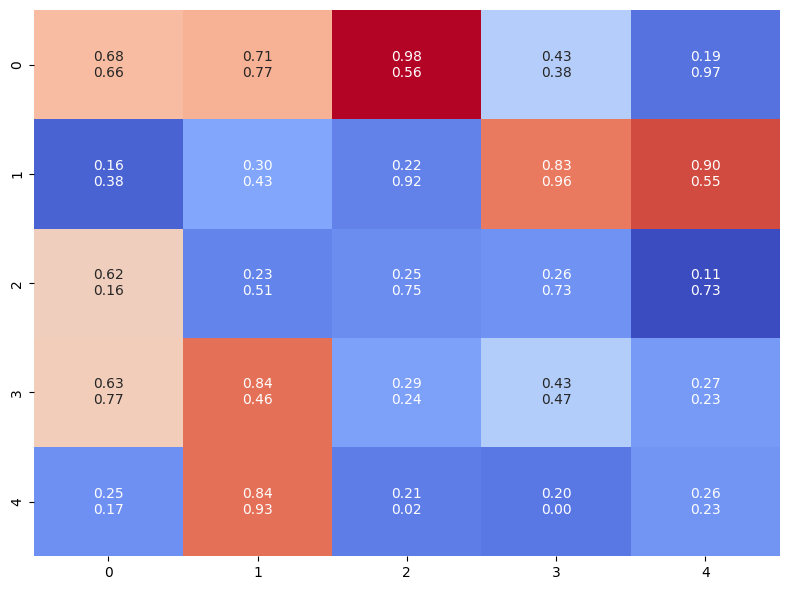

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create some example data
data1 = np.random.rand(5, 5)  # First set of values
data2 = np.random.rand(5, 5)  # Second set of values

# Combine the two data sets into strings for annotation
annot_data = np.array([["{:.2f}\n{:.2f}".format(data1[i, j], data2[i, j]) for j in range(data1.shape[1])] for i in range(data1.shape[0])])

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data1, annot=annot_data, fmt="", cmap="coolwarm", cbar=False)

# Adjust the layout to prevent overlap
plt.tight_layout()

plt.show()